- Cross validation
- random forest, logistic regression, reti neurali (?)
- one hot encoder su cabin deck, home planet e destination

# Libraries

In [28]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import missingno as mno
import seaborn as sns
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


# Training dataset and EDA

In [29]:
df = pd.read_csv('train.csv')
print(df.shape)
df.head()

(8693, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


The dataset has 14 columns and 8693 rows. Obviously each row is a passenger (identified by the primary key PassengerId). The columns have the following meanings:  

* __PassengerId__: A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.  

* __HomePlanet__: The planet the passenger departed from, typically their planet of permanent residence.

* __CryoSleep__: Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

* __Cabin__: The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

* __Destination__: The planet the passenger will be debarking to.

* __Age__: The age of the passenger.

* __VIP__: Whether the passenger has paid for special VIP service during the voyage.

* __RoomService, FoodCourt, ShoppingMall, Spa, VRDeck__: Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

* __Name__: The first and last names of the passenger.
    
* __Transported__: Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

I'm dropping the column name and passenger id because i don't think that a spacetime anomaly differentiate the people to transport knowing their names or ids.

In [30]:
df = df.drop(['PassengerId', 'Name'], axis = 1)

Apart from the target and the primary key of this dataset every column has missing values. But the following matrix tells us that there's no correlation between columns about missing values

<AxesSubplot:>

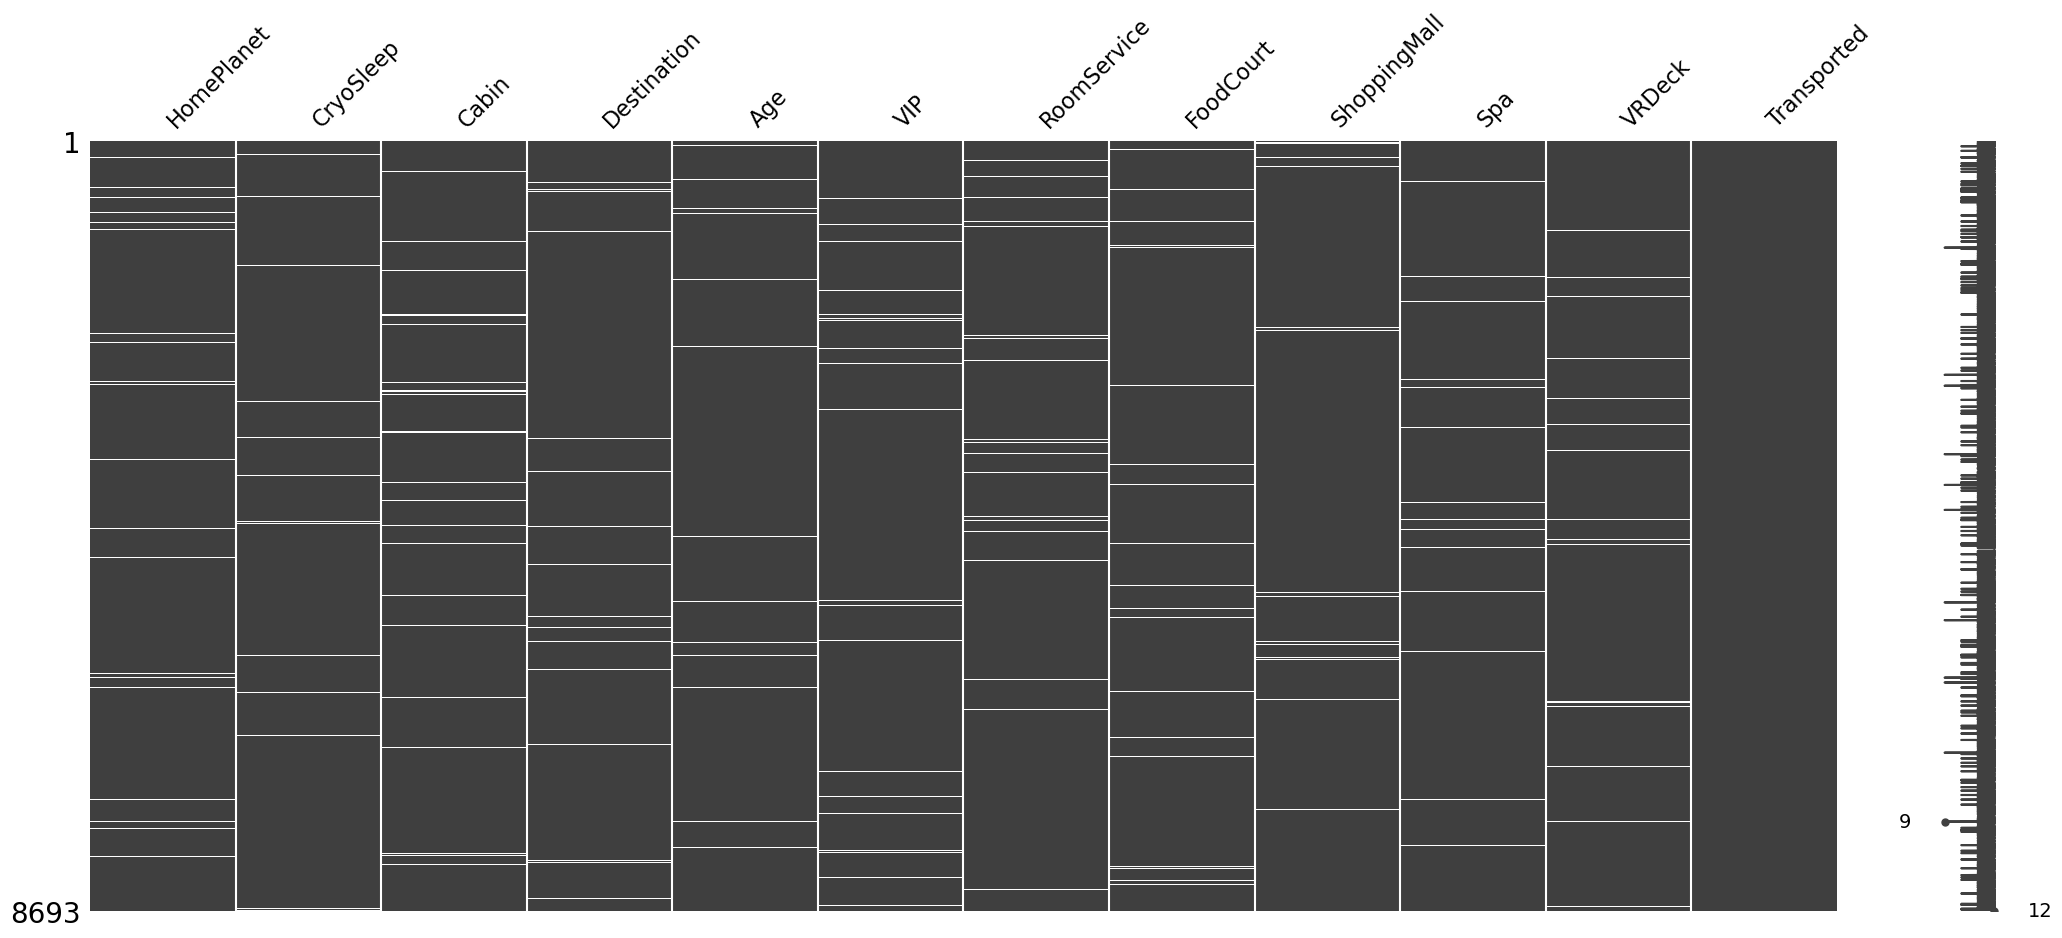

In [31]:
mno.matrix(df)

# Features

### HomePlanet

So we can see that about the half of passengers started the journey from the Earth and there are some missing values. Here the idea is to replace them with the most common category, so the Earth

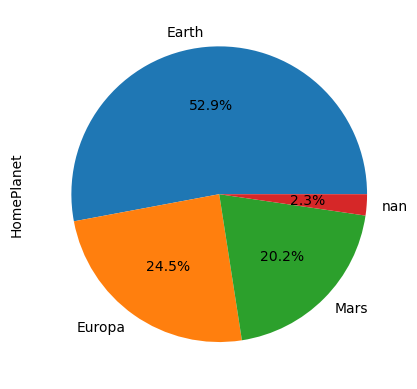

In [32]:
df['HomePlanet'] = df['HomePlanet'].astype('category')
df['HomePlanet'].value_counts(dropna = False).plot.pie(autopct='%1.1f%%')
plt.show()

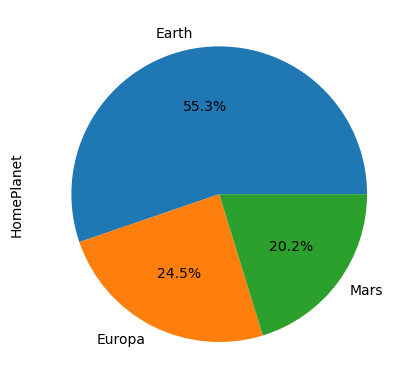

In [33]:
df['HomePlanet'] = df['HomePlanet'].fillna(df['HomePlanet'].value_counts().index[0])
df['HomePlanet'].value_counts(dropna = False).plot.pie(autopct='%1.1f%%')
plt.show()

### CryoSleep

The next plot indicates that more than half passengers didn't want Cryo sleep (crazy, it's a long journey!). For the missing values the idea is pretty simple. Every passenger that haven't spent a single penny in luxuries is sleeping for the whole journey obviously. So I assumed that all the missing values in the luxuries is 0.0. If a passenger has 0.0 expenses and NaN as CryoSleep then i will replace it with True.

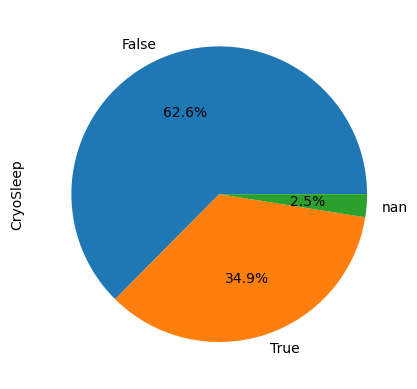

In [34]:
df['CryoSleep'].value_counts(dropna = False).plot.pie(autopct='%1.1f%%')
plt.show()

In [35]:
df['RoomService'].fillna(0.0, inplace = True)
df['FoodCourt'].fillna(0.0, inplace = True)
df['ShoppingMall'].fillna(0.0, inplace = True)
df['Spa'].fillna(0.0, inplace = True)
df['VRDeck'].fillna(0.0, inplace = True)

In [36]:
def is_cryo(a,b,c,d,e):
    if (a == 0.0) and (b == 0.0) and (c == 0.0) and (d == 0.0) and (e == 0.0):
        return True
    else:
        return False

df_nan_cryo = df[df['CryoSleep'].isnull()]
df = df.drop(df_nan_cryo.index)

df_nan_cryo['CryoSleep'] = df_nan_cryo.apply(lambda row: is_cryo(row['RoomService'], row['FoodCourt'], row['ShoppingMall'], row['Spa'], row['VRDeck']), axis = 1)

df = df.append(df_nan_cryo)
df = df.sort_index()
df['CryoSleep'] = df['CryoSleep'].astype('bool')


C:\Users\gltut\AppData\Local\Temp\ipykernel_39712\945706503.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_nan_cryo)


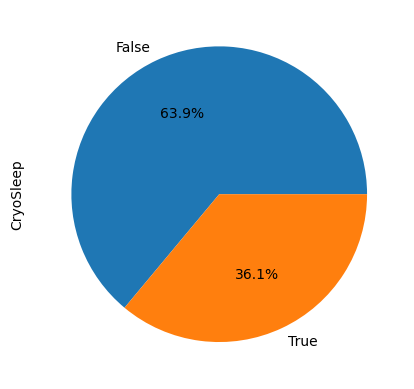

In [37]:
df['CryoSleep'].value_counts(dropna = False).plot.pie(autopct='%1.1f%%')
plt.show()

### Cabin

The column Cabin has as values a string in format A/000/A where the first character is the deck, the integer is the cabin's number and the last character is the side. I splitted the column in the 3 columns (Cabin_deck, Cabin_num, Cabin_side) because they are much easier to treat. First thing first though, in fact ,given that this is an important feature to predict the target and it's impossibile to assign with logic a value to the missing values, I'll drop the rows with nan on this feature

In [38]:
to_drop = df[df['Cabin'].isnull()].index
df.drop(to_drop, inplace = True)


df[['Cabin_deck', 'Cabin_num', 'Cabin_side' ]] = df.Cabin.str.split("/", expand = True)
df = df.drop(['Cabin'], axis = 1)

df['Cabin_deck'] = df['Cabin_deck'].replace(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'], [1, 2, 3, 4, 5, 6, 7, 8])
df['Cabin_deck'] = df['Cabin_deck'].astype('category')

df['Cabin_num'] = df['Cabin_num'].astype('int')

df['Cabin_side'] = df['Cabin_side'].replace(['P', 'S'], [1,0])
df['Cabin_side'] = df['Cabin_side'].astype('bool')


### Destination

So the destinations are TRAPPIST-1e, PSO J318.5-22, 55 Cancri e. Here there are missing values too. But as for the HomePlanet feature i really am not sure of how much meaningful can be the destination. But for data analysis sake i did the piechart and almost the 70% of passengers' destination is TRAPPIST-1e (must be cheaper!). For the missing values again, I replace them with the most common destination: TRAPPIST-1e

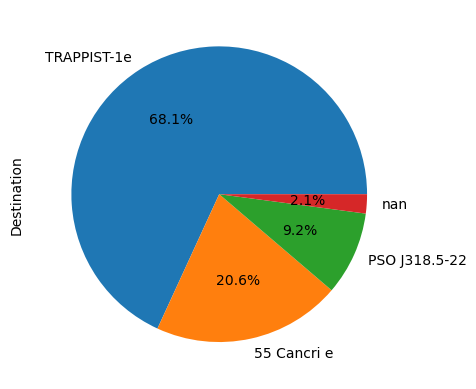

In [39]:
df['Destination'] = df['Destination'].astype('category')
df['Destination'].value_counts(dropna = False).plot.pie(autopct = '%1.1f%%')
plt.show()

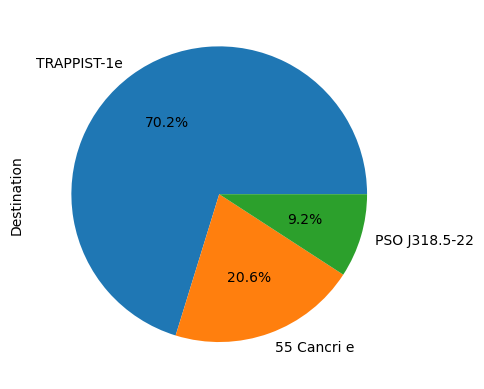

In [40]:
df['Destination'] = df['Destination'].fillna(df['Destination'].value_counts().index[0])
df['Destination'].value_counts(dropna = False).plot.pie(autopct = '%1.1f%%')
plt.show()

### Age

The histogram of the passengers' ages indicates that the majority of them is young. The distribution is quite simmetric, in fact median and mean are both really close to 28 years. But again, not sure how can passengers' age influence a natural event to hit them. For the missing values, I replaced them with the mean value.

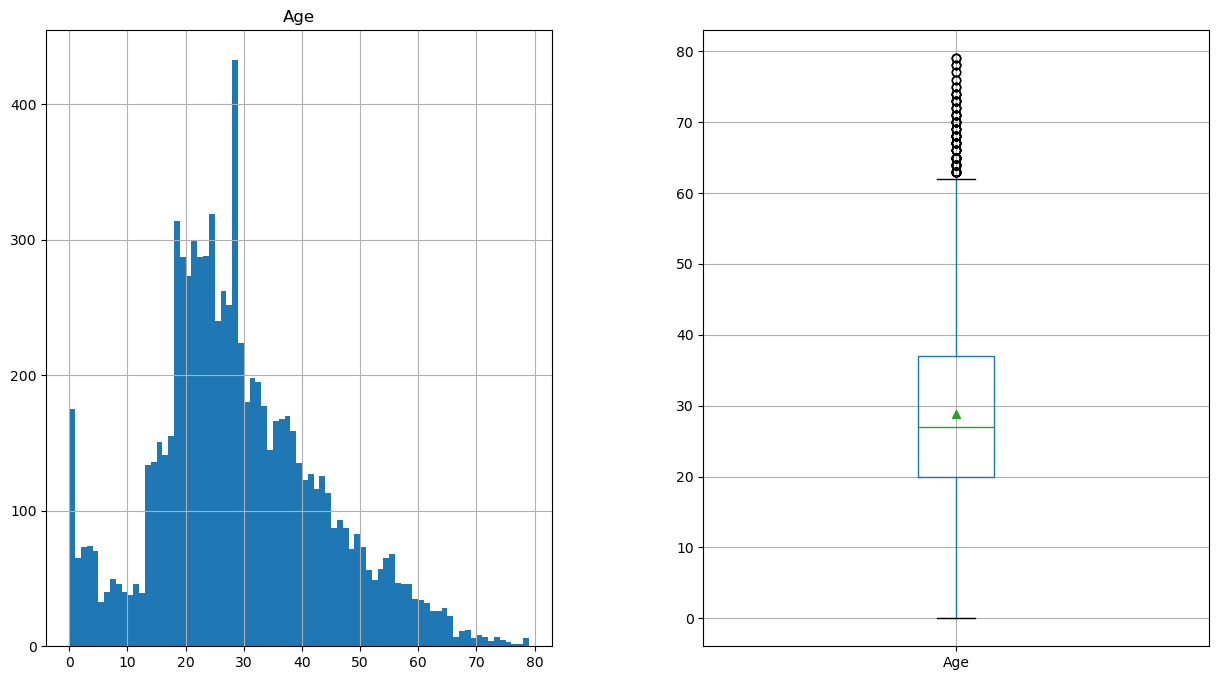

In [41]:
df['Age'].fillna(df['Age'].mean(), inplace=True)
df['Age'] = df['Age'].astype('int')

fig, ax = plt.subplots(1, 2, figsize = (15,8))

df.hist(column = 'Age', bins = len(df.Age.unique()) - 1, ax = ax[0])
df.boxplot(column = 'Age', ax = ax[1], showmeans = True)
plt.show()

### VIP

The following piechart shows the percentages of VIP passengers. Obviously is small (2.3%). Here, again there is about 2% of missing values. I didn't spend much time trying to predict them, in fact I dropped the rows.

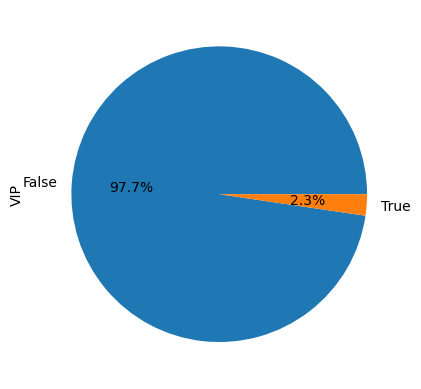

In [42]:
to_drop = df[df['VIP'].isnull()].index
df.drop(to_drop, inplace = True)
df['VIP'] = df['VIP'].astype('bool')
df['VIP'].value_counts(dropna = False).plot.pie(autopct = '%1.1f%%')
plt.show()

### Luxuries (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck)

Now it's the time of the variables that indicate the amount of money spent in room service, food, shopping, spa and vrdeck. I really don't think the anomaly is gonna be interested in how much a passenger spent in each thing. But just in case I will create a column for the total amount spent in all 5 luxuries.

In [43]:
amount_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df['Spendings'] = df[amount_columns].sum(axis = 1)
df = df.drop(amount_columns, axis = 1)

A recap of the dataset follows:

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8297 entries, 0 to 8692
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   HomePlanet   8297 non-null   category
 1   CryoSleep    8297 non-null   bool    
 2   Destination  8297 non-null   category
 3   Age          8297 non-null   int32   
 4   VIP          8297 non-null   bool    
 5   Transported  8297 non-null   bool    
 6   Cabin_deck   8297 non-null   category
 7   Cabin_num    8297 non-null   int32   
 8   Cabin_side   8297 non-null   bool    
 9   Spendings    8297 non-null   float64 
dtypes: bool(4), category(3), float64(1), int32(2)
memory usage: 251.8 KB


# Machine learning


The idea is to first use a bunch of models only on the training dataset given from Kaggle. In this way I can use cross validation to find a model that is stable. Then i use the best models using as training dataset the whole 'train.csv' and then predict the values for 'test.csv'

Moving the target from the center of the dataset to the end for my personal pleasure

In [45]:
target = df.pop('Transported')
df.insert(9, 'Transported', target)

The following correlation matrix shows us the correlation between variables according to pearson's coefficient. It's interesting the correlation between CryoSleep and the target.

In [46]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision = 3)

,CryoSleep,Age,VIP,Cabin_num,Cabin_side,Spendings,Transported
CryoSleep,1.000,-0.078,-0.080,-0.036,-0.019,-0.385,0.469
Age,-0.078,1.000,0.092,-0.129,-0.011,0.184,-0.076
VIP,-0.080,0.092,1.000,-0.099,0.010,0.161,-0.035
Cabin_num,-0.036,-0.129,-0.099,1.000,0.038,-0.214,-0.046
Cabin_side,-0.019,-0.011,0.010,0.038,1.000,-0.002,-0.105
Spendings,-0.385,0.184,0.161,-0.214,-0.002,1.000,-0.197
Transported,0.469,-0.076,-0.035,-0.046,-0.105,-0.197,1.000


But, as you know, some feature are categorical and some models don't work well with them, for example XGBoost. So I used the function get_dummies as onehot encoder.

In [47]:
df = pd.get_dummies(df, columns = ['Cabin_deck', 'HomePlanet', 'Destination'])
target = df.pop('Transported')
df.insert(20, 'Transported', target)

At this point, i did again the correlation matrix. We can notice how there are some correlation > 0.1 with some HomePlanet value and Cabin_deck.

In [48]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision = 3)

,CryoSleep,Age,VIP,Cabin_num,Cabin_side,Spendings,Cabin_deck_1,Cabin_deck_2,Cabin_deck_3,Cabin_deck_4,Cabin_deck_5,Cabin_deck_6,Cabin_deck_7,Cabin_deck_8,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Transported
CryoSleep,1.000,-0.078,-0.080,-0.036,-0.019,-0.385,-0.032,0.125,0.034,-0.067,-0.111,-0.227,0.252,-0.018,-0.111,0.097,0.034,0.063,0.092,-0.114,0.469
Age,-0.078,1.000,0.092,-0.129,-0.011,0.184,0.075,0.102,0.129,0.077,0.028,-0.020,-0.209,0.014,-0.196,0.214,0.014,0.016,-0.028,0.003,-0.076
VIP,-0.080,0.092,1.000,-0.099,0.010,0.161,0.137,0.067,0.068,0.070,-0.013,-0.059,-0.101,-0.004,-0.164,0.147,0.045,0.044,-0.002,-0.038,-0.035
Cabin_num,-0.036,-0.129,-0.099,1.000,0.038,-0.214,-0.189,-0.272,-0.262,-0.219,-0.200,0.442,0.195,-0.029,0.372,-0.491,0.064,-0.144,0.106,0.060,-0.046
Cabin_side,-0.019,-0.011,0.010,0.038,1.000,-0.002,-0.011,-0.027,-0.024,0.014,-0.007,0.028,0.004,0.015,0.016,-0.037,0.019,-0.012,0.007,0.006,-0.105
Spendings,-0.385,0.184,0.161,-0.214,-0.002,1.000,0.128,0.170,0.295,0.073,-0.017,-0.113,-0.248,0.029,-0.297,0.408,-0.069,0.137,-0.100,-0.058,-0.197
Cabin_deck_1,-0.032,0.075,0.137,-0.189,-0.011,0.128,1.000,-0.056,-0.055,-0.043,-0.060,-0.123,-0.116,-0.004,-0.190,0.303,-0.089,0.093,-0.051,-0.050,-0.005
Cabin_deck_2,0.125,0.102,0.067,-0.272,-0.027,0.170,-0.056,1.000,-0.099,-0.078,-0.109,-0.223,-0.209,-0.008,-0.344,0.549,-0.161,0.176,-0.097,-0.095,0.147
Cabin_deck_3,0.034,0.129,0.068,-0.262,-0.024,0.295,-0.055,-0.099,1.000,-0.076,-0.106,-0.217,-0.203,-0.008,-0.334,0.532,-0.156,0.169,-0.079,-0.099,0.109
Cabin_deck_4,-0.067,0.077,0.070,-0.219,0.014,0.073,-0.043,-0.078,-0.076,1.000,-0.083,-0.171,-0.160,-0.006,-0.262,0.084,0.234,0.020,-0.049,0.013,-0.033


## XGBoost

In [49]:
target = 'Transported'
X = df.loc[:, df.columns != target]
y = df[target]

Now I use the XGBoost Classifier. I use it with hyperparameter tuning and cross validation. The metric I'm using is the accuracy. At the end of the tuning I save the best model's parameters

In [73]:
max_depth_lst = list(range(3,10))
min_child_w_lst = list(range(0,3))
l_r_lst = list(range(0,3))

scores = []
models = []

# Hyperparameters' tuning
for max_depth in max_depth_lst:
    for min_child_weight in min_child_w_lst:
            for l_r in l_r_lst:
                learning_rate = l_r/10

                scores_cv = []

                for _ in range(5):
                        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=_)

                        reg = xgb.XGBClassifier(n_estimators = 500, early_stopping_rounds = 50, max_depth = max_depth, 
                                                min_child_weight = min_child_weight, learning_rate = learning_rate, booster = 'gbtree')
                                
                        reg.fit(X_train, y_train,
                                eval_set = [(X_train, y_train), (X_test, y_test)],
                                verbose = False)

                        # Predicting the target for the test dataset
                        y_pred= reg.predict(X_test)

                        score = round(accuracy_score(y_test, y_pred), 3)
                        scores_cv.append(score)
                                
                
                acc = np.mean(scores_cv)

                # Print the model's parameters
                print('*********************\nParameters:')
                print(f'Max Depth: {max_depth}')
                print(f'Min Child Weight: {min_child_weight}')
                print(f'Learning rate: {learning_rate}')
                print (f"Accuracy: {round(acc, 3)}")

                param_score = (max_depth, min_child_weight, learning_rate, acc)
                models.append(param_score)



# Selection of the best model
scores = [x[-1] for x in models]
index = scores.index(max(scores))
best_reg = models[index]

print('\n*********** Best Model ***********')
print(f'Max Depth: {best_reg[0]}')
print(f'Min Child Weight: {best_reg[1]}')
print(f'Learning rate: {best_reg[2]}')
print ("Accuracy:", round(best_reg[3], 3))

	



*********************
Parameters:
Max Depth: 3
Min Child Weight: 0
Learning rate: 0.0
Accuracy: 0.496
*********************
Parameters:
Max Depth: 3
Min Child Weight: 0
Learning rate: 0.1
Accuracy: 0.755
*********************
Parameters:
Max Depth: 3
Min Child Weight: 0
Learning rate: 0.2
Accuracy: 0.759
*********************
Parameters:
Max Depth: 3
Min Child Weight: 1
Learning rate: 0.0
Accuracy: 0.496
*********************
Parameters:
Max Depth: 3
Min Child Weight: 1
Learning rate: 0.1
Accuracy: 0.759
*********************
Parameters:
Max Depth: 3
Min Child Weight: 1
Learning rate: 0.2
Accuracy: 0.756
*********************
Parameters:
Max Depth: 3
Min Child Weight: 2
Learning rate: 0.0
Accuracy: 0.496
*********************
Parameters:
Max Depth: 3
Min Child Weight: 2
Learning rate: 0.1
Accuracy: 0.757
*********************
Parameters:
Max Depth: 3
Min Child Weight: 2
Learning rate: 0.2
Accuracy: 0.757
*********************
Parameters:
Max Depth: 4
Min Child Weight: 0
Learning rate: 

I run again the best model to visualize the confusion matrix, accuracy and feature importance.

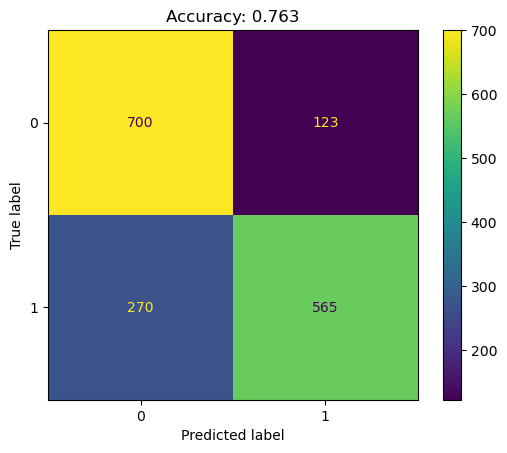

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
scores_cv = []
cm = np.array([[0,0],[0,0]])

for _ in range(5):
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y, random_state=_)

        reg = xgb.XGBClassifier(n_estimators = 500, early_stopping_rounds = 50, max_depth = best_reg[0], 
                                min_child_weight = best_reg[1], learning_rate = best_reg[2], booster = 'gbtree')
                
        reg.fit(X_train, y_train,
                eval_set = [(X_train, y_train), (X_test, y_test)],
                verbose = False)

        # Predicting the target for the test dataset
        y_pred= reg.predict(X_test)

        score = accuracy_score(y_test, y_pred)
        scores_cv.append(score)
        
        cm += confusion_matrix(y_test, y_pred)
     

acc = round(np.mean(scores_cv), 3)
cm_mean = cm//5

disp = ConfusionMatrixDisplay(cm_mean)
disp.plot()
plt.title(f'Accuracy: {acc}')
plt.show()
        



As we saw in the correlation matrix, the feature importance highlight the CryoSleep feature as the most important and that's interesting, but also some of the decks. It's interesting because the decks and CryoSleep referenced also to the position of the passengers. So maybe this anomaly took only a part of the ship.

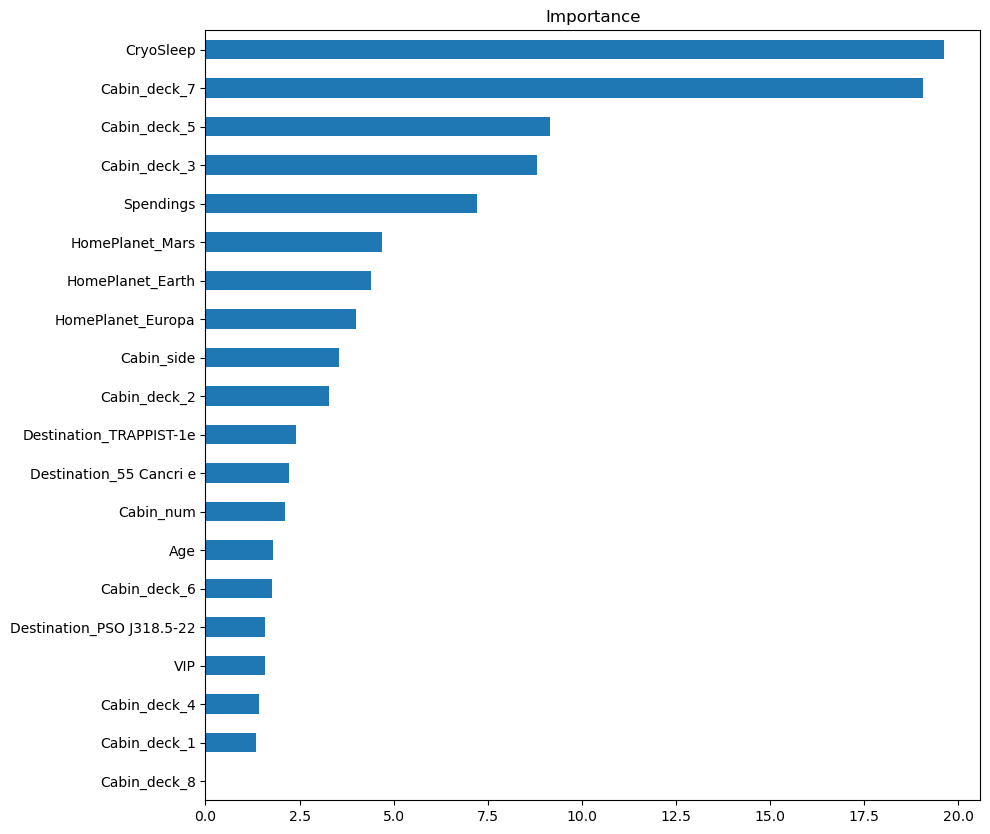

In [52]:
impor = pd.DataFrame(data = reg.feature_importances_ * 100, index = reg.feature_names_in_, columns = ['importance'])

impor.sort_values('importance').plot(kind = 'barh', title = 'Importance', legend=False, figsize = (10,10))
plt.show()

To investigate the correlation CryoSleep and Transported, I did a barplot to see how many of the non-sleeping passengers were taken and how many of the sleeping. It seems like a passenger was more likely to be taken if he was in cryo-sleep. If a passenger was not in cryosleep he had almost 33% of probability to be taken (I know that the two affirmations seem the same thing but looking at the barplot makes you understand the difference from the two situations).

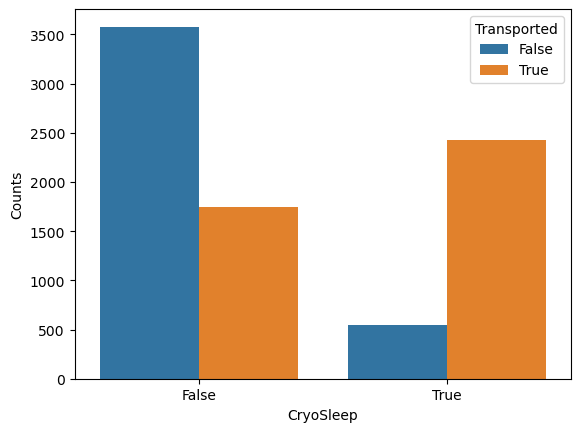

In [53]:
a = df.groupby(['Transported', 'CryoSleep']).size().reset_index(name = 'Counts')
sns.barplot(x = 'CryoSleep', y = 'Counts', hue = 'Transported', data = a)
plt.show()

# Test data

Now I'll import the test dataset, for which I don't have the target. All the preprocessing steps are the same as the training dataset.

In [54]:
df_test = pd.read_csv('test.csv')


df_test = df_test.drop(['PassengerId', 'Name'], axis = 1)

# HomePlanet
df_test['HomePlanet'] = df_test['HomePlanet'].fillna(df_test['HomePlanet'].value_counts().index[0])
df_test['HomePlanet'] = df_test['HomePlanet'].astype('category')

# Luxuries
df_test['RoomService'].fillna(0.0, inplace = True)
df_test['FoodCourt'].fillna(0.0, inplace = True)
df_test['ShoppingMall'].fillna(0.0, inplace = True)
df_test['Spa'].fillna(0.0, inplace = True)
df_test['VRDeck'].fillna(0.0, inplace = True)

# CryoSleep
def is_cryo(a,b,c,d,e):
    if (a == 0.0) and (b == 0.0) and (c == 0.0) and (d == 0.0) and (e == 0.0):
        return True
    else:
        return False

df_nan_cryo = df_test[df_test['CryoSleep'].isnull()]
df_test = df_test.drop(df_nan_cryo.index)

df_nan_cryo['CryoSleep'] = df_nan_cryo.apply(lambda row: is_cryo(row['RoomService'], row['FoodCourt'], row['ShoppingMall'], row['Spa'], row['VRDeck']), axis = 1)

df_test = df_test.append(df_nan_cryo)
df_test = df_test.sort_index()
df_test['CryoSleep'] = df_test['CryoSleep'].astype('bool')

# Cabin
to_drop = df_test[df_test['Cabin'].isnull()].index
df_test.drop(to_drop, inplace = True)


df_test[['Cabin_deck', 'Cabin_num', 'Cabin_side' ]] = df_test.Cabin.str.split("/", expand = True)
df_test = df_test.drop(['Cabin'], axis = 1)

df_test['Cabin_deck'] = df_test['Cabin_deck'].replace(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'], [1, 2, 3, 4, 5, 6, 7, 8])
df_test['Cabin_deck'] = df_test['Cabin_deck'].astype('category')

df_test['Cabin_num'] = df_test['Cabin_num'].astype('int')

df_test['Cabin_side'] = df_test['Cabin_side'].replace(['P', 'S'], [1,0])
df_test['Cabin_side'] = df_test['Cabin_side'].astype('bool')


# Destination
df_test['Destination'] = df_test['Destination'].astype('category')
df_test['Destination'] = df_test['Destination'].fillna(df_test['Destination'].value_counts().index[0])

# Age
df_test['Age'].fillna(df_test['Age'].mean(), inplace=True)
df_test['Age'] = df_test['Age'].astype('int')

# VIP
to_drop = df_test[df_test['VIP'].isnull()].index
df_test.drop(to_drop, inplace = True)
df_test['VIP'] = df_test['VIP'].astype('bool')

# Luxuries
amount_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df_test['Spendings'] = df_test[amount_columns].sum(axis = 1)
df_test = df_test.drop(amount_columns, axis = 1)

df_test = pd.get_dummies(df_test, columns = ['Cabin_deck', 'HomePlanet', 'Destination'])




C:\Users\gltut\AppData\Local\Temp\ipykernel_39712\2288611382.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test.append(df_nan_cryo)


Now for the model the training data is the whole 'train.csv' file, and the predictions are to be made for the 'test.csv' file

In [55]:
target = 'Transported'
X_train = df.loc[:, df.columns != target]
y_train = df[target]
X_test = df_test

In [56]:
reg = xgb.XGBClassifier(n_estimators = 500, early_stopping_rounds = 50, max_depth = best_reg[0], 
                                min_child_weight = best_reg[1], learning_rate = best_reg[2], booster = 'gbtree')
                
reg.fit(X_train, y_train,
        eval_set = [(X_train, y_train)],
        verbose = False)

# Predicting the target for the test dataset
y_pred= reg.predict(X_test)

Here the feature importance is a little different, only because the fact that a passenger came from the Earth has more importance here than in the previous training. But apart from this the most important features are always the odd decks and the cryosleep features.

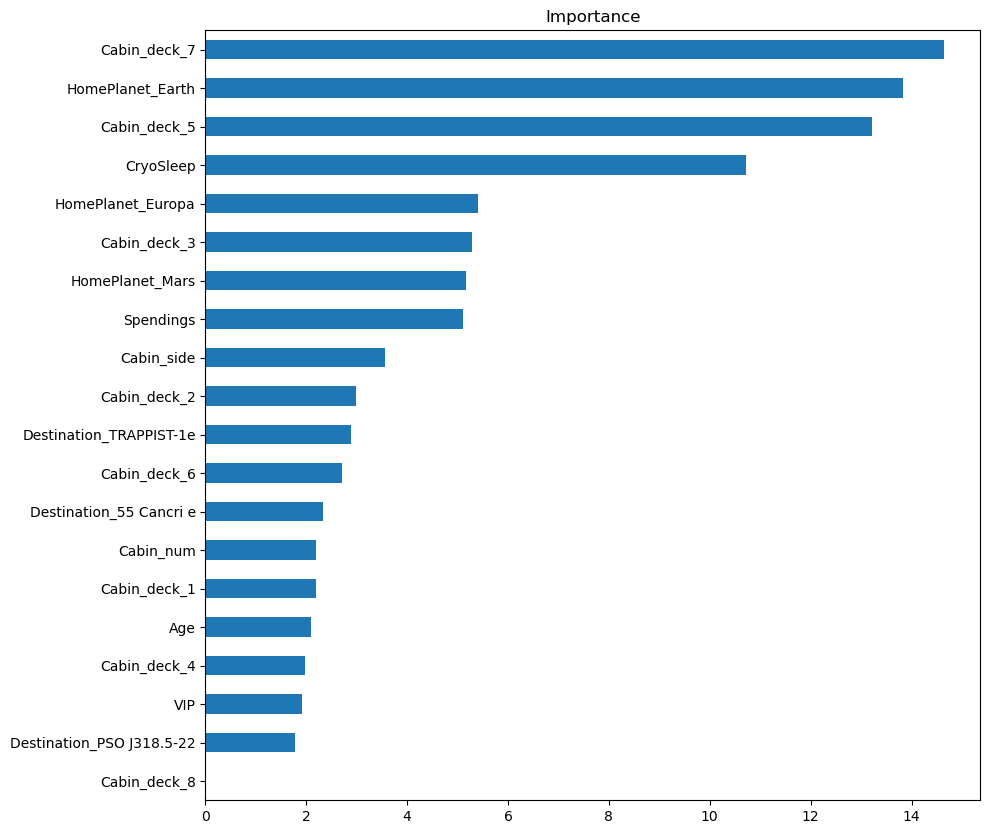

In [57]:
impor = pd.DataFrame(data = reg.feature_importances_ * 100, index = reg.feature_names_in_, columns = ['importance'])
impor.sort_values('importance').plot(kind = 'barh', title = 'Importance', legend=False, figsize = (10,10))
plt.show()

Here I append to the test dataset the predictions and I made a piechart to make you understand the percentages of passengers taken. It's almost the half of them.

<AxesSubplot:ylabel='Transported'>

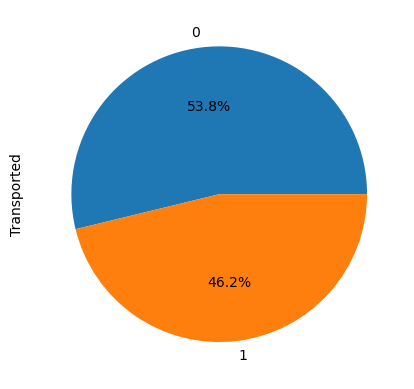

In [58]:
df_test['Transported'] = y_pred
df_test['Transported'].value_counts().plot.pie(autopct = '%1.1f%%')